In [1]:
import base64
import json
import math
import numpy
import scipy.linalg
import matplotlib as mpl

%matplotlib inline

import matplotlib.pyplot as plt

import pyspark
from pyspark import SparkContext

Part (a)
--------

In [2]:
def parse(x):
    digit = json.loads(x)
    array = numpy.fromstring(base64.b64decode(digit["data"]),dtype=numpy.ubyte)
    return (digit["label"], array)

In [3]:
digits = sc.textFile("s3n://stat-37601/digits.base64.json").map(parse)

# indexed_digit is RDD of tuples (digit, index)
# where each digit is a tuple (label, pixel_array)
indexed_digits = digits.zipWithIndex()

In [4]:
# Ok, get the first 3/4 of 60,000, i.e., 45000
training_digits = indexed_digits.filter(lambda x: x[1] <= 45000)
test_digits = indexed_digits.filter(lambda x: x[1] > 45000)

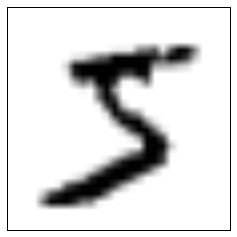

In [5]:
def sight(img):
    image = img.astype(float)/256
    fig = plt.imshow(image.reshape(28,28))
    fig.set_cmap('gray_r')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

sight(training_digits.take(1)[0][0][1])

In [6]:
# get image array from ((label, array), index) objects in training_digits array
X = training_digits.map(lambda x: numpy.matrix(x[0][1]))

normalize = (float(1) / float(45000))

mean_pixelmatrix = X.reduce(lambda a, b: numpy.matrix(a) + numpy.matrix(b)) 
mean_pixelmatrix = normalize * mean_pixelmatrix

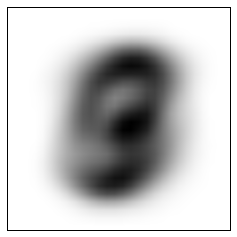

In [7]:
sd_pixelmatrix = X.map(lambda x: numpy.array(x - mean_pixelmatrix)).map(lambda x: numpy.multiply(x, x)).reduce(lambda a, b: a + b)
sd_pixelmatrix = normalize * sd_pixelmatrix

sight(sd_pixelmatrix)

Note that the sd_pixelmatrix has some entries which are exactly zero. These correspond to places where no pixels, for any of our training data, differ from each other (and hence don't differ from the mean). The z-scores of such entries would be 0. 

Doing elementwise division, we get nan's in these spots, so we'll replace them with the corrected z-score 0:

In [8]:
sd_pixelmatrix[sd_pixelmatrix == 0.0] = 1.0

demeaned_digits = X.map(lambda x: numpy.array(x - mean_pixelmatrix))

# Honestly, we ran this whole notebook using centered_digits, but the results are much less nice.
# The percent of variance accounted for by the first principal component is like 86%.

# I believe this is because we are normalizing each pixel, so that minor variation of mostly-white pixels 
# is counted on the same scale as large variation in the pixels which are often written on--which have 
# higher initial variance initially.

centered_digits = demeaned_digits.map(lambda x: numpy.divide(x, numpy.array(sd_pixelmatrix)))

In [9]:
def contrib(x):
    x_i = numpy.matrix(x)
    
    return numpy.transpose(x_i) * x_i


#covariance_matrix = centered_digits.map(contrib).reduce(lambda a, b: a + b)

covariance_matrix = demeaned_digits.map(contrib).reduce(lambda a, b: a + b)
covariance_matrix = normalize * covariance_matrix

In [10]:
print str(covariance_matrix)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [11]:
eigenvalues, eigenvectors = numpy.linalg.eig(covariance_matrix)

In [12]:
# Numpy doesn't guarantee that the eigenvectors are sorted by descending eigenvalue--we'll sort them to be sure.

indices = numpy.argsort(eigenvalues)
    
sorted_eigenvals = eigenvalues[indices][::-1]

eigenvecs = numpy.transpose(numpy.matrix(eigenvectors))

sorted_eigenvecs = numpy.array(eigenvecs)[indices][::-1]

In [13]:
sorted_eigenvecs

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

Note that according to the numpy documentation, the i-th eigenvectors reported is given by v[:,i], NOT v[i,:].

In [14]:
# Convert vector back to scale necessary for adequate visualization 
def convert_back(thing):     
    scaled_thing = numpy.array(numpy.transpose(thing)) 
    
    ## If we were to do centered_digits instead, do
    # scaled_thing = numpy.array(numpy.transpose(thing)) * numpy.array(sd_pixelmatrix) 
    
    transformed_thing = scaled_thing + numpy.array(mean_pixelmatrix)
    return transformed_thing
    

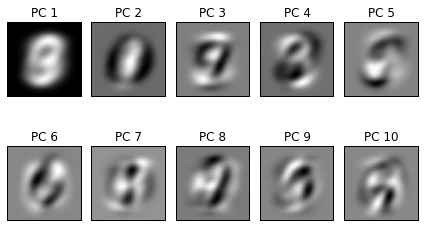

In [15]:
top10 = [sorted_eigenvecs[i,:] for i in range(0,10)]
pc_names = ["PC " + str(i+1) for i in range(0,10)]

def show_me_things(things, names):
    for k, img in enumerate(things):
        n_cols = 5
        n_rows = int(math.floor(float(len(things)) / float(5)))
        
        plt.subplot(n_rows, n_cols, k+1)
        plt.title(names[k])
        
        image = img.astype(float)
        fig = plt.imshow(image.reshape(28,28))
        fig.set_cmap('gray_r')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False) 
        
    plt.tight_layout()
    plt.show()


show_me_things(top10, pc_names)

Part (b)
--------

In [16]:
# total variance is the sum of the eigenvalues
total_variance = numpy.sum(sorted_eigenvals)
total_variance

5728709.1056185113

In [17]:
# proportion of variance accounted for by the i-th principal component given by the i-th eigenvector
# is the proportion of the i-th eigenvalue to the sum of eigenvalues:
prop_of_variance = sorted_eigenvals / total_variance

prop_of_variance[0]

0.43554393384004031

In [18]:
# Plot variance accounted for by each of the first n principal components:
def plot_variance(n):
    thingy = plt.bar(range(n), prop_of_variance[0:n])
    plt.xlabel("Principal Component #")
    plt.ylabel("Proportion of Variance")
    plt.show()
    
plot_variance(30)

Part (c)
--------

In [19]:
# Take an RDD of standardized images and an integer k, 
# and computes the reconstructed results using the first k Principal Components from training_digits
def reconstruct(dataset, first_k):
    # When we sorted it, we made sure the eigenvalues would be the rows of sorted_eigenvecs
    vq = numpy.transpose(numpy.matrix(sorted_eigenvecs[0:first_k,:]))
    
    hatmatrix = vq * numpy.transpose(vq)

    reconstructed = dataset.map(lambda x: hatmatrix * numpy.transpose(numpy.matrix(x)))
    
    return reconstructed


def visualize_reconstructed(dataset, first_k, sample_r):
    reconstructed = reconstruct(dataset, first_k)
    afewthings = reconstructed.take(sample_r)
    afewthings_converted = [convert_back(thing) for thing in afewthings]

    thing_names = ["digit " + str(i+1) for i in range(0,sample_r)]
    
    show_me_things(afewthings_converted, thing_names)

In [20]:
visualize_reconstructed(demeaned_digits,10,10)

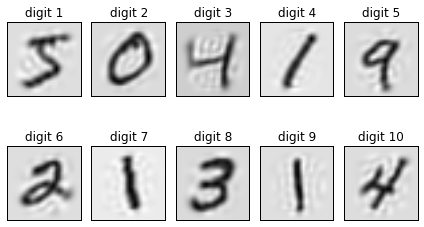

In [21]:
visualize_reconstructed(demeaned_digits,100,10)

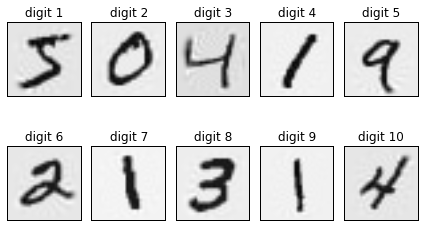

In [22]:
visualize_reconstructed(demeaned_digits,300,10)

In [23]:
visualize_reconstructed(demeaned_digits,500,10)

In [24]:
visualize_reconstructed(demeaned_digits,780,10)

Part (d)
--------

In [25]:
all_digits = indexed_digits.map(lambda x: x[0][1]) 

demeaned_all_digits = all_digits.map(lambda x: x - mean_pixelmatrix)

#centered_all_digits = demeaned_all_digits.map(lambda x: x / sd_pixelmatrix)

def reconstruction_error(first_k):
    vq = numpy.transpose(numpy.matrix(sorted_eigenvecs[0:first_k,:]))
    
    ident = numpy.matrix(numpy.identity(784))
    hatmatrix = vq * numpy.transpose(vq)
    diff_matrix = ident - hatmatrix 

    recon = demeaned_all_digits.map(lambda x: diff_matrix * numpy.transpose(numpy.matrix(x)))
    
    ss_tot = recon.map(lambda x: numpy.sum(numpy.array(x) * numpy.array(x))).reduce(lambda a, b: a + b)
    
    return ss_tot



This takes a couple of minutes to run. If you want it to go faster, you can use a shorter list of m's:

In [26]:
ms = range(0, 750, 50) + [783]

Since it's more informative about how much the reconstruction error drops for large m, 
we also plot the log reconstruction error.

In [27]:
log_recon_errs = [math.log(reconstruction_error(m)) for m in ms]

In [28]:
plt.xlabel("First k Principal Components")
plt.ylabel("Reconstruction Error")
plt.plot(ms, numpy.exp(log_recon_errs))

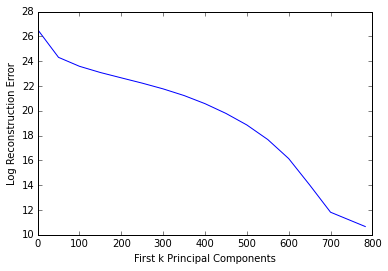

In [29]:
plt.xlabel("First k Principal Components")
plt.ylabel("Log Reconstruction Error")
plt.plot(ms, log_recon_errs)

In [30]:
ct = all_digits.count()

In [31]:
ct

60000

In [32]:
min(log_recon_errs)

10.667020324270437

In [33]:
# RMSE per pixel, using 50 factors:
math.sqrt(math.exp(log_recon_errs[1] - math.log(ct * 784)))

27.712487258977195